# LSTM Code - Multiple encoding methods




<b> We will implement LSTM and in next python file we will implement LSTM with 

<b> 1. GLVOE 
    
<b> 2. CBOW 
    
<b> 3. Skipgram </b> 

The data set was taken from UCI Machine Learning Repo
It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.

Alberto, T. & Lochter, J. (2015). YouTube Spam Collection [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C58885.

## 1. Load libraries

In [5]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import sys, re, bs4, nltk, sklearn, matplotlib
from bs4 import BeautifulSoup
import datasets, transformers 
from copy import deepcopy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#import gensim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report
from collections import defaultdict
import torch.optim as optim

## 2. Get data

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: C:\Users\Ashutosh\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
youtube_spam_collection = fetch_ucirepo(id=380) 
  
# data (as pandas dataframes) 
X = youtube_spam_collection.data.features 
y = youtube_spam_collection.data.targets 
  
# metadata 
print(youtube_spam_collection.metadata) 
  
# variable information 
print(youtube_spam_collection.variables) 


{'uci_id': 380, 'name': 'YouTube Spam Collection', 'repository_url': 'https://archive.ics.uci.edu/dataset/380/youtube+spam+collection', 'data_url': 'https://archive.ics.uci.edu/static/public/380/data.csv', 'abstract': 'It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Text'], 'num_instances': 1956, 'num_features': 3, 'feature_types': [], 'demographics': [], 'target_col': ['CLASS'], 'index_col': ['VIDEO', 'COMMENT_ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C58885', 'creators': ['T.C. Alberto', 'J.V. Lochter'], 'intro_paper': None, 'additional_info': {'summary': 'The table below lists the datasets, the YouTube video ID, the amount of samples in ea

## 3. Methodology

We will prepeocess the data, tokenize, clean it (stemming, lemmization), encode it (bag of words, tf-idf), then use multiple methodes to classify it and compare resutls

    ```Input data
    pre-processing
        A --> Toeknization
        B --> Stemming/Lemmization
        C --> Encoding (Bag of Words, TF-IDF)
    Create Embeddings
        D --> GLOVE
        E --> Word2Vec- CBOW
        F --> Word2Vec - Skipgram
    DL Model
        G. --> Define model
        H. --> Train model
        I. --> Evaluate

In [7]:
for i in X['CONTENT'][0:5]:
    print(i)

Huh, anyway check out this you[tube] channel: kobyoshi02
Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!
just for test I have to say murdev.com
me shaking my sexy ass on my channel enjoy ^_^ ﻿
watch?v=vtaRGgvGtWQ   Check this out .﻿


## 4. Data Cleaning

In [8]:
# We want to remove URL as comment as it will confuse the model but we will keep a flag that a url watch present here, 
#as it might be a strong indicator of a spam comment

X_all = [re.sub(r'http\S+|www\S+|https\S+', 'url', i, flags=re.MULTILINE) for i in X['CONTENT']]

# Similarly for watch, we will remove complext suffix but keep the word watch as an input to out model
X_all = [re.sub(r'watch\?v=\S+', 'watch', i, flags=re.MULTILINE) for i in X_all]

# Remove any html tags by mistake
X_all = [BeautifulSoup(i, "html.parser").get_text() for i in X_all]

# for any emoji or emoticon replace it with the word "emoji" as it can be a useful feature
X_all = [re.sub("[:;][)|(DP]","emoji",i) for i in X_all]

# any number does not look like year should be replaced with an identifier number

def not_number(string):
    string = re.sub(",","",string)
    try:
        float(string)
        return False
    except ValueError:
        return True
    
def check_range(string_no):
    string_no = re.sub(",","",string_no)
    if(float(string_no) <= 2100.0 and float(string_no) >= 1800.0):
        return(True)
    else:
        return(False)

def remove_suprious_num(snt):
    token_words = word_tokenize(snt)
    changed_words = [i if not_number(i) else "year" if  check_range(i) else "large number" for i in token_words]
    return(" ".join(changed_words))

X_all = [remove_suprious_num(i) for i in X_all]

# convert all to lower case
X_all = [i.casefold() for i in X_all]

# romve extra white space 
X_all = [re.sub(r'[^\w\s]', '', i) for i in X_all]

X_all = [re.sub(r'\s+', ' ', i).strip() for i in X_all]



C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_12948\787672344.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  X_all = [BeautifulSoup(i, "html.parser").get_text() for i in X_all]


## 4. Split into test and train data

In [9]:
# Let us check the distirbution of labels, if it is highly imbalanced
y.value_counts()

CLASS
1        1005
0         951
Name: count, dtype: int64

The labels seem to be very well balanced, hence we need not worry about sampling techniques (oversampling/undersampling/smote,etc).

In [10]:
# we will use y to stratify so the distribution of labels is simialr in training and test data
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

Let us check the distribution in training and test data

In [11]:
print(y_train.value_counts())
print(y_test.value_counts())

CLASS
1        804
0        760
Name: count, dtype: int64
CLASS
1        201
0        191
Name: count, dtype: int64


## 5. Pre-processing and tokenization

### 5a. Remove stop words

In [12]:
#print(stopwords)
stop_words = set(stopwords.words("english"))

In [13]:
def remove_stop_words(sent):
    token_words = word_tokenize(sent)
    clean_token_words = [i for i in token_words if i not in stop_words]
    return(" ".join(clean_token_words))

In [14]:
X_train = [remove_stop_words(i) for i in X_train]
X_test = [remove_stop_words(i) for i in X_test]
X_train[0:10]

['video large number views large number million people earth',
 'head like large number years ago time flies',
 'large number billions year',
 'wtf subscribe channel thanx emoji',
 'omg',
 'please become first subscriber thank',
 'everyone come check new gta large number gameplay right watch',
 'remember back popular everyone school shuffling crazy',
 'url please halp project',
 'haha funny see salt westerners top views youtube goes video dont even understand keep salt']

### 5b. Normalization - Lemmization

In [15]:
def normalize_data(sent,lemmitizer):
    token_words = word_tokenize(sent)
    clean_tokens = [lemmitizer.lemmatize(i) for i in token_words]
    return(" ".join(clean_tokens)) 

lemmitizer = WordNetLemmatizer()
X_train = [normalize_data(i,lemmitizer) for i in X_train]
X_test = [normalize_data(i,lemmitizer) for i in X_test]
X_train[0:10]

['video large number view large number million people earth',
 'head like large number year ago time fly',
 'large number billion year',
 'wtf subscribe channel thanx emoji',
 'omg',
 'please become first subscriber thank',
 'everyone come check new gta large number gameplay right watch',
 'remember back popular everyone school shuffling crazy',
 'url please halp project',
 'haha funny see salt westerner top view youtube go video dont even understand keep salt']

# Embedding - Glove

<b> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.We will use a pre-trained golve model on wikipedia data. We will load it and use it to create embeddings for our corpus.\
\
To download the pre-trained model and use golve refer to - https://nlp.stanford.edu/projects/glove/

In [16]:
def load_glove_model(glove_dict):
    model = {}
    with open(glove_dict, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            word = lemmitizer.lemmatize(word)
            vector = np.asarray(values[1:], dtype='float32')
            model[word] = vector
    return model

glove_model = load_glove_model('./glove.6B.50d.txt')  # Example for 50-dimensional vectors

In [17]:
def get_glove_embedding(sent):
    emb_vec = []
    tokens = word_tokenize(sent)
    for token in tokens:
        temp_vec = glove_model.get(token, np.zeros(50))
        emb_vec.append(temp_vec)
    return(emb_vec)
    

In [18]:
X_train_glove_embed = [get_glove_embedding(i) for i in X_train]
X_test_glove_embed = [get_glove_embedding(i) for i in X_test]

In [19]:
def pad_sentence_vectors(vectors_list, max_len_sentence, embedding_size):
    padded_vectors = []
    for vecs in vectors_list:
        if len(vecs) < max_len_sentence:
            pad_length = max_len_sentence - len(vecs)
            vecs.extend([np.zeros(embedding_size)] * pad_length)
        else:
            vecs = vecs[:max_len_sentence]
        padded_vectors.append(vecs)
    return np.array(padded_vectors)


In [20]:
padded_embeddings_X_train_glove = pad_sentence_vectors(X_train_glove_embed,25,50)
padded_embeddings_X_test_glove = pad_sentence_vectors(X_test_glove_embed,25,50)
print(padded_embeddings_X_train_glove.shape)

(1564, 25, 50)


## Create training tensor dataset  for GLOVE

In [21]:
X_tensor_train = torch.tensor(padded_embeddings_X_train_glove, dtype=torch.float32)    
print(X_tensor_train.shape)

#The expected sequence of nn.Conv1d is (batch_size, channels, sequence_length)
# hence we change the shape (1564, 15, 50) to (1564, 50, 15)
X_tensor_train = X_tensor_train.permute(0, 2, 1)
print(X_tensor_train.shape)

y_tensor_train = torch.tensor(np.array(y_train), dtype=torch.long)

dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=10, shuffle=False,drop_last=False)


X_tensor_test = torch.tensor(padded_embeddings_X_test_glove, dtype=torch.float32)    
print(X_tensor_test.shape)

#The expected sequence of nn.Conv1d is (batch_size, channels, sequence_length)
# hence we change the shape (1564, 15, 50) to (1564, 50, 15)
X_tensor_test = X_tensor_test.permute(0, 2, 1)
print(X_tensor_test.shape)

y_tensor_test = torch.tensor(np.array(y_test), dtype=torch.long)

dataset_test = TensorDataset(X_tensor_test, y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False,drop_last=False)

torch.Size([1564, 25, 50])
torch.Size([1564, 50, 25])
torch.Size([392, 25, 50])
torch.Size([392, 50, 25])


# Embedding - CBOW

CBOW or Continous Bag of Words is word embedding technique. It creates embedding by trying to predict the word by using surrounding words. Surrounding is defined by context window.

In [22]:
X_train[0]

'video large number view large number million people earth'

In [23]:
# Let us tokenize words
train_corpus = [word_tokenize(i) for i in X_train]
test_corpus = [word_tokenize(i) for i in X_test]

First we need to create a dictionary with frequency. We will use it to filter for words with atleast >= 5 frequency and for rare word we change in UNK

In [24]:
all_words = {}
for i in train_corpus:
    for j in i:
        if j not in all_words:
            all_words[j] = 1
        else:
            all_words[j] += 1

In [25]:
# Filter the dict 
filtered_all_words = {i:j for i,j in all_words.items() if j >= 3 }

<b> Let us create 2 indexes, word to index and index to words </b>

In [26]:
word_to_idx = {
    '<PAD>': 0,
    '<UNK>': 1}
for i in filtered_all_words.keys():
    if (i not in word_to_idx):
        word_to_idx[i] = len(word_to_idx)

In [27]:
inx_to_word = {}
for i,j in word_to_idx.items():
    inx_to_word[j] = i

<b> Let us pad both train and test corpus to similar lengths </b>

(array([1.237e+03, 1.630e+02, 6.700e+01, 4.600e+01, 3.000e+01, 1.700e+01,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  0. ,  10.7,  21.4,  32.1,  42.8,  53.5,  64.2,  74.9,  85.6,
         96.3, 107. ]),
 <BarContainer object of 10 artists>)

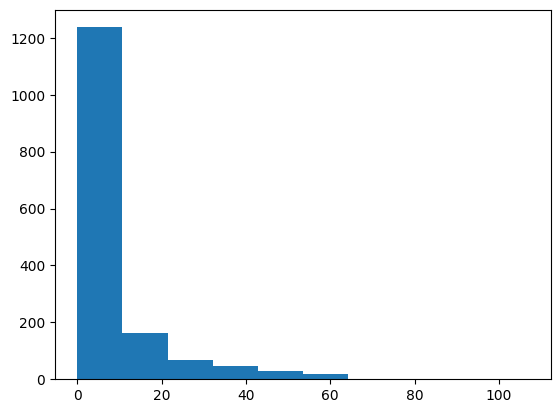

In [28]:
len_of_words = []
for i in train_corpus:
    #print(i)
    #print(len(i))
    len_of_words.append(len(i))
plt.hist(len_of_words)

In [29]:
def do_padding (wrd_crps, pad_length):
    padded_corpus = []
    for i in wrd_crps:
        if len(i) >= pad_length:
            sent = i[0:pad_length]
        else:
            sent = i + (pad_length-len(i)) * ['<PAD>']
        padded_corpus.append(sent)
    return(padded_corpus)


In [30]:
padded_train_corpus = do_padding(train_corpus,12)
padded_test_corpus = do_padding(test_corpus,12)

<b> Change the list of words corpus to list of indexes

In [31]:
def change_to_index(wrd_crps,word_dict):
    ret_list = []
    for i in wrd_crps:
        sent = [word_dict[k] if k in word_dict else 1 for k in i]
        ret_list.append(sent)
    return(ret_list)

## Let us create a dataset of contex and target words

In [32]:
corpus = []
target = []
for i in  train_corpus:   
    sent = []
    for j,k in enumerate(i):       
        if j > 2 and j < len(i) - 2:
            context = ([i[j-2],i[j-1],i[j+1],i[j+2]])
            target.append(i[j])
            corpus.append(context)

In [33]:
print(len(corpus))
print(len(target))

7841
7841


In [34]:
encoded_target = []
for i in target:
    if(i in word_to_idx):
        enc = word_to_idx[i]
    else:
        enc = 1
    encoded_target.append(enc)

In [35]:
encoded_context = []
for i in corpus:
    encoded_neigh = []
    for j in i:
        if(j in word_to_idx):
            enc = word_to_idx[j]
        else:
            enc = 1
        encoded_neigh.append(enc)
    encoded_context.append(encoded_neigh)

In [36]:
print(len(encoded_context))
print(len(encoded_target))

7841
7841


## Let us create data for CBOW encoding

In [37]:
X_tensor_train_cbow = torch.tensor(encoded_context, dtype=torch.long) 
y_tensor_train_cbow = torch.tensor(encoded_target, dtype=torch.long)

In [38]:
dataset_train_cbow = TensorDataset(X_tensor_train_cbow, y_tensor_train_cbow)
dataloader_train_cbow = DataLoader(dataset_train_cbow, batch_size=10, shuffle=False,drop_last=False)

In [39]:
vocab_size = len(word_to_idx)

# CBOW Model

In [40]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, padding_idx):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_idxs):
        #print("input to embed")
        #print(context_idxs)
        embeds = self.embeddings(context_idxs)
        mask = (context_idxs != self.embeddings.padding_idx).unsqueeze(-1).float()
        masked_embeds = embeds * mask 
        lengths = mask.sum(dim=1).clamp(min=1)
        avg_embed = masked_embeds.sum(dim=1) / lengths 
        #print("output of embed")
        #print(embeds)
        #print("shape of embed output")
        #print(embeds.shape)
        #avg_embed = embeds.mean(dim=1) 
        #print("after mean")
        #print(avg_embed.shape)
        #print("input to linear layer")
        #print(avg_embed)
        out = self.linear(avg_embed) 
        #print("output of linear layer")
        #print(out)
        return out


In [41]:
model_cbw = CBOW(vocab_size, embedding_dim = 50, padding_idx=0)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cbw.parameters(), lr=0.01)


In [42]:
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0

    for context_batch, target_batch in dataloader_train_cbow:
        
        outputs = model_cbw(context_batch) 
        loss = loss_fn(outputs, target_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/20, Loss: 3661.4337
Epoch 2/20, Loss: 2509.5882
Epoch 3/20, Loss: 1984.5742
Epoch 4/20, Loss: 1611.0222
Epoch 5/20, Loss: 1347.1973
Epoch 6/20, Loss: 1169.6983
Epoch 7/20, Loss: 1026.4545
Epoch 8/20, Loss: 930.8497
Epoch 9/20, Loss: 853.7886
Epoch 10/20, Loss: 805.2388
Epoch 11/20, Loss: 768.7215
Epoch 12/20, Loss: 727.9563
Epoch 13/20, Loss: 699.3661
Epoch 14/20, Loss: 688.0523
Epoch 15/20, Loss: 663.6880
Epoch 16/20, Loss: 636.5288
Epoch 17/20, Loss: 617.4927
Epoch 18/20, Loss: 609.0713
Epoch 19/20, Loss: 599.1746
Epoch 20/20, Loss: 584.3016


In [40]:
# Check accuracy of my CBOW model

In [43]:
model_cbw.eval()  

correct = 0
total = 0

with torch.inference_mode():  
    for context_batch, target_batch in dataloader_train_cbow:
        outputs = model_cbw(context_batch)     
        predicted = torch.argmax(outputs, dim=1)  
        correct += (predicted == target_batch).sum().item()
        total += target_batch.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8417


In [44]:
len(model_cbw.embeddings(torch.tensor([4])).squeeze(0).tolist())

50

In [45]:
(model_cbw.embeddings(torch.tensor([0])).squeeze(0).tolist())

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## Now let us create a corpus of embedded vectors for training and testing data


Created index values corpus

In [46]:
padded_train_corpus_encoded = []
for i in padded_train_corpus:
    sent = [word_to_idx[j] if j in word_to_idx else 1 for j in i]
    padded_train_corpus_encoded.append(sent)

In [47]:
padded_test_corpus_encoded = []
for i in padded_test_corpus:
    sent = [word_to_idx[j] if j in word_to_idx else 1 for j in i]
    padded_test_corpus_encoded.append(sent)

Now change all indexes to embedding values

In [48]:
model_cbw.embeddings(torch.tensor([1]))

tensor([[-0.1306, -0.3280, -0.0750, -0.1300,  0.0642, -0.1433, -0.4171, -0.1534,
          0.1246, -0.0748,  0.0847, -0.2814,  0.0397, -0.0774,  0.4458,  0.0449,
         -0.0818, -0.0231, -0.5214, -0.1480, -0.0991, -0.2671,  0.0806, -0.3679,
         -0.0903, -0.1182, -0.1862, -0.2450, -0.2729,  0.3462, -0.0665, -0.1306,
         -0.0733,  0.2761, -0.3023, -0.1378,  0.0954, -0.2080, -0.4112, -0.2492,
         -0.0520, -0.0233,  0.2505,  0.0764,  0.1327,  0.4381, -0.3206,  0.2613,
         -0.0140, -0.4254]], grad_fn=<EmbeddingBackward0>)

In [49]:
embed_train_vector = []
for i in padded_train_corpus_encoded:
    sent = []
    for j in i:
        emb_word = (model_cbw.embeddings(torch.tensor([j])).squeeze(0).tolist())
        sent.append(emb_word)
    embed_train_vector.append(sent) 

In [50]:
embed_test_vector = []
for i in padded_test_corpus_encoded:
    sent = []
    for j in i:
        emb_word = (model_cbw.embeddings(torch.tensor([j])).squeeze(0).tolist())
        sent.append(emb_word)
    embed_test_vector.append(sent) 

In [51]:
len(padded_test_corpus)

392

# Creating Training dataset for CBOW Embedding

In [52]:
X_tensor_train_cbow = torch.tensor(embed_train_vector, dtype=torch.float32)    
print(X_tensor_train_cbow.shape)

#The expected sequence of nn.Conv1d is (batch_size, channels, sequence_length)
# hence we change the shape (1564, 15, 50) to (1564, 50, 15)
X_tensor_train_cbow = X_tensor_train_cbow.permute(0, 2, 1)
print(X_tensor_train_cbow.shape)

y_tensor_train = torch.tensor(np.array(y_train), dtype=torch.long)

dataset_train_cbow_final = TensorDataset(X_tensor_train_cbow, y_tensor_train)
dataloader_train_cbow_final = DataLoader(dataset_train_cbow_final, batch_size=10, shuffle=False,drop_last=False)


X_tensor_test_cbow = torch.tensor(embed_test_vector, dtype=torch.float32)    
print(X_tensor_test_cbow.shape)

#The expected sequence of nn.Conv1d is (batch_size, channels, sequence_length)
# hence we change the shape (1564, 15, 50) to (1564, 50, 15)
X_tensor_test_cbow = X_tensor_test_cbow.permute(0, 2, 1)
print(X_tensor_test_cbow.shape)

y_tensor_test = torch.tensor(np.array(y_test), dtype=torch.long)

dataset_test_cbow_final = TensorDataset(X_tensor_test_cbow, y_tensor_test)
dataloader_test_cbow_final = DataLoader(dataset_test_cbow_final, batch_size=10, shuffle=False,drop_last=False)

torch.Size([1564, 12, 50])
torch.Size([1564, 50, 12])
torch.Size([392, 12, 50])
torch.Size([392, 50, 12])


# LSTM Model

In [53]:
class LSTM_spam_classify(nn.Module):
    def __init__(self, input_dim = 50, embed_dim = 50, hidden_dim = 100, output_dim = 2, n_layers=2, dropout=0.2):
        super(LSTM_spam_classify, self).__init__()
        #self.embed =  nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)
        # lstm layer expects (batch_size, seq_len, input_size)
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        #x = self.embed(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden_state = h_n[-1]  
        x = self.dropout(last_hidden_state)
        out = self.fc(x) 
        return out


# LSTM Model with GLOVE Encoding

In [54]:
model = LSTM_spam_classify()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses = []
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0
    model.train()
    for inputs, labels in dataloader_train:
        #inputs = inputs.float()
        #labels = labels.float()
        #inputs = inputs.permute(0,2,1)
        #print(inputs.shape)
        #print(labels.shape)
        outputs = model(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels.squeeze(1))
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        #get_norm()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader_train)
    print(avg_train_loss)
    train_losses.append(avg_train_loss)

    #print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
 

0.6895752158134606
0.6458763265685671
0.5441114033103749
0.5080407996466205
0.48336169835488507
0.4675503780317914
0.45420198142528534
0.44938402153124474
0.44397543095479347
0.437213965756878
0.4336284573195846
0.4294320481123438
0.4188842463550294
0.4163253396559673
0.41063647964008293
0.4020929489355938
0.406751430575635
0.397431654843745
0.3929959912398818
0.38933882435226136
0.3890811477781861
0.38657740674390917
0.38389354101886414
0.38169049822790607
0.38520637963702725
0.37795452752215847
0.37998580496022655
0.37408385562241836
0.3725186747255599
0.37014767819434213
0.3600863599971791
0.3586684953017979
0.3522737789187272
0.3556991436156877
0.3487977829708415
0.3476884334472714
0.33748576132829783
0.3394838646528827
0.3379926317294312
0.3309104584845578


# Let us swap the prediction method into the code that doesnt work

In [56]:
# Predictions on training data

model.eval() 

train_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_train:  
        outputs_train = model(inputs) 
        preds = torch.argmax(outputs_train, dim=1) 
        train_preds.extend(preds.numpy())


In [57]:
model.eval() 

test_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_test:  
        outputs_test = model(inputs) 
        preds = torch.argmax(outputs_test, dim=1) 
        test_preds.extend(preds.numpy())

In [58]:
# Training accuracy
cnn_train_accuracy = accuracy_score(y_train, train_preds)
# Testing accuracy
cnn_test_accuracy = accuracy_score(y_test, test_preds)

cnn_train_precision = precision_score(y_train, train_preds)
cnn_test_precision = precision_score(y_test, test_preds)

cnn_train_recall = recall_score(y_train, train_preds)
cnn_test_recall = recall_score(y_test, test_preds)

print("training accuracy is {0}".format(round(cnn_train_accuracy,3)))
print("test accuracy is {0}".format(round(cnn_test_accuracy,3)))

print("training precision is {0}".format(round(cnn_train_precision,3)))
print("test precision is {0}".format(round(cnn_test_precision,3)))

print("training recall is {0}".format(round(cnn_train_recall,3)))
print("test recall is {0}".format(round(cnn_test_recall,3)))

print(classification_report(y_train, train_preds))
print(classification_report(y_test, test_preds))

training accuracy is 0.846
test accuracy is 0.788
training precision is 0.835
test precision is 0.766
training recall is 0.873
test recall is 0.846
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       760
           1       0.83      0.87      0.85       804

    accuracy                           0.85      1564
   macro avg       0.85      0.85      0.85      1564
weighted avg       0.85      0.85      0.85      1564

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       191
           1       0.77      0.85      0.80       201

    accuracy                           0.79       392
   macro avg       0.79      0.79      0.79       392
weighted avg       0.79      0.79      0.79       392



# LSTM Model with CBOW Encoding

In [59]:
model2 = LSTM_spam_classify()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
train_losses = []
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0
    model.train()
    for inputs, labels in dataloader_train_cbow_final:
        #inputs = inputs.float()
        #labels = labels.float()
        #inputs = inputs.permute(0,2,1)
        #print(inputs.shape)
        #print(labels.shape)
        outputs = model2(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels.squeeze(1))
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        #get_norm()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader_train)
    print(avg_train_loss)
    train_losses.append(avg_train_loss)

    #print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
 

0.6840422738129925
0.6042166564874588
0.5055857901550402
0.45802175979705373
0.41882342954350127
0.3664397383286695
0.3281823939815828
0.31787481220664493
0.2732369003781847
0.26099183754461586
0.2222289748394945
0.2484635910980261
0.2076655717145438
0.19477549467567995
0.18484180598596858
0.17500262515868542
0.14796504734831442
0.1161871700900589
0.10174518486389973
0.1296663056164802
0.11311000940585687
0.07092812583058077
0.08792220305348895
0.0670159558619515
0.05837612884611508
0.07682991373333427
0.06277988837797574
0.04749971480260063
0.03454258891395708
0.024392171333775952
0.06128988093766977
0.05329338686995725
0.0624088977927351
0.06751248120236845
0.03049023125311775
0.02830711540756421
0.022240571595332066
0.02060391557243301
0.017780498667999398
0.022607800845122303


In [57]:
# Predictions on training data

model2.eval() 

train_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_train_cbow_final:  
        outputs_train = model2(inputs) 
        preds = torch.argmax(outputs_train, dim=1) 
        train_preds.extend(preds.numpy())


In [60]:
model2.eval() 

test_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_test_cbow_final:  
        outputs_test = model2(inputs) 
        preds = torch.argmax(outputs_test, dim=1) 
        test_preds.extend(preds.numpy())

In [61]:
# Training accuracy
cnn_train_accuracy = accuracy_score(y_train, train_preds)
# Testing accuracy
cnn_test_accuracy = accuracy_score(y_test, test_preds)

cnn_train_precision = precision_score(y_train, train_preds)
cnn_test_precision = precision_score(y_test, test_preds)

cnn_train_recall = recall_score(y_train, train_preds)
cnn_test_recall = recall_score(y_test, test_preds)

print("training accuracy is {0}".format(round(cnn_train_accuracy,3)))
print("test accuracy is {0}".format(round(cnn_test_accuracy,3)))

print("training precision is {0}".format(round(cnn_train_precision,3)))
print("test precision is {0}".format(round(cnn_test_precision,3)))

print("training recall is {0}".format(round(cnn_train_recall,3)))
print("test recall is {0}".format(round(cnn_test_recall,3)))

print(classification_report(y_train, train_preds))
print(classification_report(y_test, test_preds))

training accuracy is 0.846
test accuracy is 0.758
training precision is 0.835
test precision is 0.743
training recall is 0.873
test recall is 0.806
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       760
           1       0.83      0.87      0.85       804

    accuracy                           0.85      1564
   macro avg       0.85      0.85      0.85      1564
weighted avg       0.85      0.85      0.85      1564

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       191
           1       0.74      0.81      0.77       201

    accuracy                           0.76       392
   macro avg       0.76      0.76      0.76       392
weighted avg       0.76      0.76      0.76       392



# Conclusion

We can observe overfitting to be an issue with CBOW as it was trained on a small dataset which is not present in glove

# Skipgram

A skipgram is where we use target word to predict context word. The will be 1 to 1 mapping for words with target words repeating multiple time

### Data creation for Skipgram

We will reuse the datastructure we built for CBOW and reformat it for skipgram

In [62]:
train_corpus[0]

['video',
 'large',
 'number',
 'view',
 'large',
 'number',
 'million',
 'people',
 'earth']

In [63]:
def create_skipgram_corpus(train_corpus):
    for i in train_corpus:
        target_list = []
        context_list = []
        for idx,j in enumerate(i):
            if len(i) > 3:
                #print(j)
                if idx == 0 :
                    #print(000)
                    context_list.append(i[idx + 1])
                    context_list.append(i[idx + 2])
                    target_list += [j]*2
                elif idx == 1 :
                    #print(111)
                    context_list.append(i[idx - 1])
                    context_list.append(i[idx + 1])
                    context_list.append(i[idx + 2])
                    target_list += [j]*3
                elif idx == (len(i) - 1):
                    #print(222)
                    context_list.append(i[idx - 1])
                    context_list.append(i[idx - 2])
                    target_list += [j]*2
                elif idx == (len(i) - 2):
                    #print(222)
                    context_list.append(i[idx - 1])
                    context_list.append(i[idx - 2])
                    context_list.append(i[idx + 1])
                    target_list += [j]*3
                elif (idx >= 2) and (idx < (len(i) - 2)):
                    #print(333)
                    context_list.append(i[idx - 2])
                    context_list.append(i[idx - 1])
                    context_list.append(i[idx + 1])
                    context_list.append(i[idx + 2])

                    target_list += [j] * 4
                else:
                    #print(444)
                    context_list.append(i[idx - 1])
                    context_list.append(i[idx + 1])
                    target_list += [j] * 2
            else:
                pass
    return(target_list,context_list)
            

In [64]:
target_skip, context_skip = create_skipgram_corpus(train_corpus)

In [65]:
def convert_list_to_num(list_wrds,word_dict):
    skip_num = []
    for i in list_wrds:
        if i in  word_dict:
            skip_num.append(word_dict[i])
        else:
            skip_num.append(1)
    return(skip_num)

In [66]:
target_skip_num = convert_list_to_num(target_skip,filtered_all_words)
context_skip_num = convert_list_to_num(context_skip,filtered_all_words)

In [67]:
target_skip_num[1:25]
context_skip_num[1:25]

[1, 15, 1, 1, 15, 4, 1, 5, 4, 1, 5, 3, 1, 1, 3, 5, 1, 5, 5, 274, 5, 3, 274, 4]

<b> Let us create a dictionary for a target and label matching vector </b>

In [70]:
comprehensive_dict = {}
for i,j in zip(target_skip_num,context_skip_num):
    if i not in comprehensive_dict:
        comprehensive_dict[i] = [j]
    else:
        comprehensive_dict[i].append(j)

In [88]:
for element in comprehensive_dict[4]:
    print(f'{element} -> {type(element)}')

15 -> <class 'int'>
1 -> <class 'int'>
1 -> <class 'int'>
5 -> <class 'int'>
274 -> <class 'int'>
24 -> <class 'int'>
24 -> <class 'int'>


### Creating a pytorch training dataset for Skipgram

In [74]:
target_skip_tensor = torch.tensor(target_skip_num, dtype = torch.long)
context_skip_tensor = torch.tensor(context_skip_num, dtype = torch.long)

dataset_train_skip = TensorDataset(target_skip_tensor, context_skip_tensor)
dataloader_train_skip = DataLoader(dataset_train_skip, batch_size=10, shuffle=False,drop_last=False)

### Build a Skipgram Model

In [75]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center):
        embed = self.embedding(center)
        out = self.output(embed)
        return out


In [76]:
vocab_size = len(filtered_all_words) + 1
embed_dim = 50

model_skip = SkipGramModel(vocab_size, embed_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_skip.parameters(), lr=0.01)

# Training
for epoch in range(10):
    total_loss = 0
    for center_batch, context_batch in dataloader_train_skip:
        output = model_skip(center_batch)  
        
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, context_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 46.7078
Epoch 2, Loss: 37.9226
Epoch 3, Loss: 30.0930
Epoch 4, Loss: 22.8505
Epoch 5, Loss: 17.7048
Epoch 6, Loss: 14.8496
Epoch 7, Loss: 13.4327
Epoch 8, Loss: 12.7436
Epoch 9, Loss: 12.3577
Epoch 10, Loss: 12.1121


In [94]:
predictions = {}
with torch.no_grad():
    correct = 0
    total = 0
    for center, context in dataloader_train_skip:
        #print(center)
        output = model_skip(center)  
        preds = torch.argmax(output, dim=1)
        for inx,targ in enumerate(center):
            val = int(int(preds[inx]) in comprehensive_dict[int(targ)])
            correct += val
            #print("prediction",preds[inx])
            #print("actual",comprehensive_dict[int(targ)])
        #correct += (preds == context).sum().item()
        total += context.size(0)
    accuracy = correct / total
    print(f"Skip-gram prediction accuracy: {accuracy:.4f}")


Skip-gram prediction accuracy: 1.0000


In [87]:
for i,j in enumerate(torch.tensor([15, 15,  4,  4,  4,  1,  1,  1,  1,  1])):
    print(float(i))

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


# Get word embeddings for each word

In [103]:
embed_train_vector_skip = []
for i in padded_train_corpus_encoded:
    sent = []
    for j in i:
        #print(j)
        if j == 0:
            emb_word = torch.tensor(np.zeros(50))
        else:
            emb_word = (model_skip.embedding(torch.tensor([j-1])).squeeze(0).tolist())
        sent.append(emb_word)
    embed_train_vector_skip.append(sent) 

In [104]:
embed_test_vector_skip = []
for i in padded_test_corpus_encoded:
    sent = []
    for j in i:
        #print(j)
        if j == 0:
            emb_word = torch.tensor(np.zeros(50))
        else:
            emb_word = (model_skip.embedding(torch.tensor([j-1])).squeeze(0).tolist())
        sent.append(emb_word)
    embed_test_vector_skip.append(sent) 

In [105]:
X_tensor_train_skip = torch.tensor(embed_train_vector_skip, dtype=torch.float32)    
print(X_tensor_train_skip.shape)

#The expected sequence of nn.Conv1d is (batch_size, channels, sequence_length)
# hence we change the shape (1564, 15, 50) to (1564, 50, 15)
X_tensor_train_skip = X_tensor_train_skip.permute(0, 2, 1)
print(X_tensor_train_skip.shape)

y_tensor_train = torch.tensor(np.array(y_train), dtype=torch.long)

dataset_train_skip_final = TensorDataset(X_tensor_train_skip, y_tensor_train)
dataloader_train_skip_final = DataLoader(dataset_train_skip_final, batch_size=10, shuffle=False,drop_last=False)


X_tensor_test_skip = torch.tensor(embed_test_vector_skip, dtype=torch.float32)    
print(X_tensor_test_skip.shape)

#The expected sequence of nn.Conv1d is (batch_size, channels, sequence_length)
# hence we change the shape (1564, 15, 50) to (1564, 50, 15)
X_tensor_test_skip = X_tensor_test_skip.permute(0, 2, 1)
print(X_tensor_test_skip.shape)

y_tensor_test = torch.tensor(np.array(y_test), dtype=torch.long)

dataset_test_skip_final = TensorDataset(X_tensor_test_skip, y_tensor_test)
dataloader_test_skip_final = DataLoader(dataset_test_skip_final, batch_size=10, shuffle=False,drop_last=False)

torch.Size([1564, 12, 50])
torch.Size([1564, 50, 12])
torch.Size([392, 12, 50])
torch.Size([392, 50, 12])


In [106]:
model3 = LSTM_spam_classify()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
train_losses = []
num_epochs = 40

for epoch in range(num_epochs):
    running_loss = 0
    model3.train()
    for inputs, labels in dataloader_test_skip_final:
        #inputs = inputs.float()
        #labels = labels.float()
        #inputs = inputs.permute(0,2,1)
        #print(inputs.shape)
        #print(labels.shape)
        outputs = model3(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels.squeeze(1))
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        #get_norm()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(dataloader_train)
    print(avg_train_loss)
    train_losses.append(avg_train_loss)

    #print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
 

0.17676285383807624
0.17378935084980765
0.20718121243889925
0.17680333602200649
0.17288797714148357
0.16919684694830778
0.17604487640842512
0.17746795666445592
0.17357014280975244
0.1728519189889264
0.17319917982550942
0.17321116567417316
0.16529188471235287
0.17784722329704625
0.16098718468550663
0.15442916826837383
0.15604617944948232
0.16263728422723758
0.16356975884194586
0.1582968214135261
0.15384659417875254
0.1447944176045193
0.13393385490034795
0.12408586634192498
0.10846863478232341
0.10480645023713446
0.09372278442902929
0.08625432363693501
0.06537670474855384
0.05481062842248257
0.054647522492061375
0.05549473755334498
0.05533438702084267
0.036883278067704216
0.029119872382047118
0.026307348726216442
0.024907106658959892
0.0357026521192128
0.015942147796510892
0.011890258048890918


In [118]:
# Predictions on training data

model3.eval() 

train_preds = []
actual = []

with torch.no_grad(): 
    for inputs, labels in dataloader_train_skip_final:  
        actual.append(labels)
        outputs_train = model3(inputs) 
        preds = torch.argmax(outputs_train, dim=1) 
        train_preds.extend(preds.numpy())
print(len(train_preds))
print(len(actual))

1564
157


In [119]:
model3.eval() 

test_preds = []

with torch.no_grad(): 
    for inputs, labels in dataloader_test_skip_final:  
        outputs_test = model3(inputs) 
        preds = torch.argmax(outputs_test, dim=1) 
        test_preds.extend(preds.numpy())

In [120]:
# Training accuracy
cnn_train_accuracy = accuracy_score(y_train, train_preds)
# Testing accuracy
cnn_test_accuracy = accuracy_score(y_test, test_preds)

cnn_train_precision = precision_score(y_train, train_preds)
cnn_test_precision = precision_score(y_test, test_preds)

cnn_train_recall = recall_score(y_train, train_preds)
cnn_test_recall = recall_score(y_test, test_preds)

print("training accuracy is {0}".format(round(cnn_train_accuracy,3)))
print("test accuracy is {0}".format(round(cnn_test_accuracy,3)))

print("training precision is {0}".format(round(cnn_train_precision,3)))
print("test precision is {0}".format(round(cnn_test_precision,3)))

print("training recall is {0}".format(round(cnn_train_recall,3)))
print("test recall is {0}".format(round(cnn_test_recall,3)))

print(classification_report(y_train, train_preds))
print(classification_report(y_test, test_preds))

training accuracy is 0.754
test accuracy is 0.99
training precision is 0.772
test precision is 0.985
training recall is 0.741
test recall is 0.995
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       760
           1       0.77      0.74      0.76       804

    accuracy                           0.75      1564
   macro avg       0.75      0.75      0.75      1564
weighted avg       0.76      0.75      0.75      1564

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       191
           1       0.99      1.00      0.99       201

    accuracy                           0.99       392
   macro avg       0.99      0.99      0.99       392
weighted avg       0.99      0.99      0.99       392

